<a href="https://colab.research.google.com/github/mkandrewhuang301/CS362/blob/main/Module%204%3A%20Burst%20imaging%20in%20computational%20photography%20and%20microscopy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> **Student Names and IDs**:

>Andrew Huang: ah629
>Jason Shang: zs110

All homework is to be submitted through Gradescope. For each submission, you will submit both a PDF file and a Jupyter notebook. We will usually grade your PDF file only (typically we will **NOT** run your code, so make sure you have all the results are displayed correctly) and the Jupyter notebook is for backup purpose (if we see something wrong in your code).

Homework is to be done either individually or in pairs, and working in pairs is strongly encouraged: This helps you discuss concepts and get unstuck when you encounter difficulties. It also helps us return your graded work earlier, since we'll have to read fewer assignments. No other groupings are allowed.

# Homework 4

We will use the same image burst we used in class for the following questions.

76
(186, 248, 4)


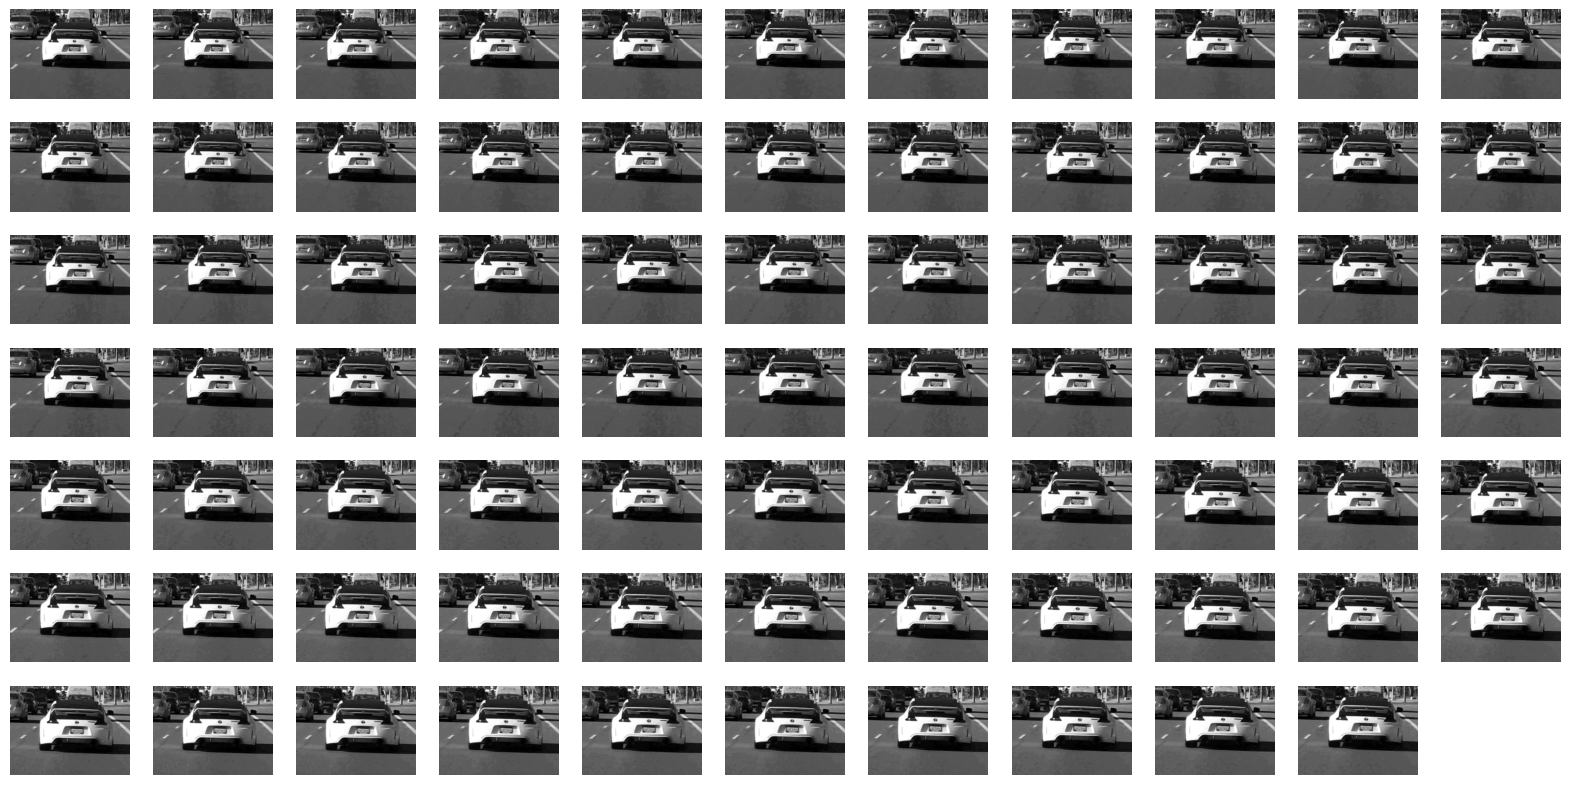

In [1]:
import numpy as np, cv2
import matplotlib.pyplot as plt

import imageio, urllib.request

url = "https://i.stack.imgur.com/lui1A.gif"
fname = "tmp.gif"

imdata = urllib.request.urlopen(url).read()
open(fname,'wb+').write(imdata)

gif = imageio.mimread(fname)

imgs = [ cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in gif ]

print(len(gif))
print(gif[-1].shape)

fig = plt.figure(figsize=(20,10))

rows, cols = 7, 11
k = 0
for i in range(rows):

  for j in range(cols):
    while k < len(imgs):
      ax = plt.subplot(rows,cols,k+1)
      ax.imshow( imgs[k], cmap='gray' )
      ax.axis('off')
      k += 1

## Motion Estimation






### Question 1
We will first register these images using sparse optimal flow. Sparse optical flow selects a sparse feature set of pixels (e.g. interesting features such as edges and corners) to track its velocity vectors (motion). The extracted features are passed in the optical flow function from frame to frame to ensure that the same points are being tracked. To find good features, we will use `cv2.goodFeatureToTrack` from opencv. To correcly identify features in the first frame, you will need to try out different values for parameters in `cv2.goodFeatureToTrack`. Plot the selected features. Is there anything in common among all the selected features? (Note: Try to extract a total of less than 8 features, you can get better quality features by setting quality level to a higher value and make minDistance bigger to avoid redundancy)


### Answer

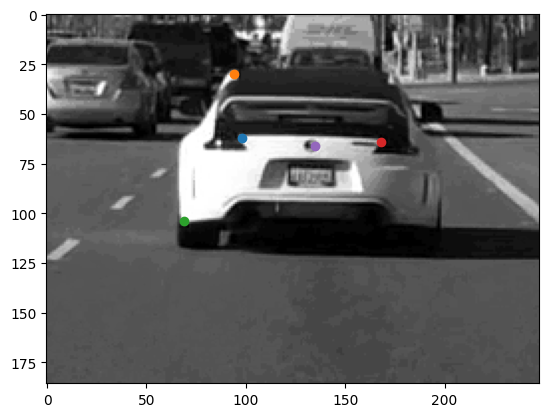

In [2]:
features = cv2.goodFeaturesToTrack(imgs[0], 7, 0.49, 20)
plt.figure()
plt.imshow(imgs[0], cmap='gray')

for feature in features:
  plt.scatter(feature[0][0], feature[0][1])

These selected features are usually a border between pixels with very high or very low values (ex. from white to black).

### Question 2
Now we will track the motion across all frames using the features we extracted in **Question 1**. Specifically, we will use `cv2.calcOpticalFlowPyrLK()`. This function has multiple parameters: window size, pyramid level, criteria, etc. For this question, we will use the parameters given below. The `cv2.calcOpticalFlowPyrLK()` function implements the Lucas-Kanade Optical flow motion tracking algorithm. The function has three outputs: the position of features in the following frame, the status of features (if the features are still present in the following frame) and an error. We will use the first two outputs. First, check if the extracted features are present in all 76 frames. Then, for every feature, track its location through the sequence until they are no longer present. Show the motion trajectories for each extracted feature. To do this, plot the first frame of the video sequence (using `cmap=plt.cm.gray`) and superimpose the trajectories as red lines. Also plot a red circle (`'or'`) at the beginning of each track. Did any feature disappear midway through the sequence?

In [ ]:
lk_params = dict(winSize = (20,20), maxLevel = 2, criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 15, 0.001))

### Answer

In [ ]:
trajectories = []
for feature in features:
  trajectories.append([(feature[0][0], feature[0][1])])
trajectories

[[(98.0, 62.0)],
 [(94.0, 30.0)],
 [(69.0, 104.0)],
 [(168.0, 64.0)],
 [(135.0, 66.0)]]

In [ ]:
prev_features = features.copy() # set to initial features

for i in range(1, len(imgs)):
  prev, cur = imgs[i-1], imgs[i]
  next_points, status, error = cv2.calcOpticalFlowPyrLK(
      prev, cur, prev_features, None, **lk_params
  )

  if next_points is not None:
    valid_new_features = next_points[status==1]
    if (len(valid_new_features) != len(prev_features)):
      print("a feature disappeared!")

  for i in range(len(valid_new_features)):
    x, y = valid_new_features[i].ravel()
    trajectories[i].append((x, y))

  prev_features = valid_new_features.reshape(-1, 1, 2)

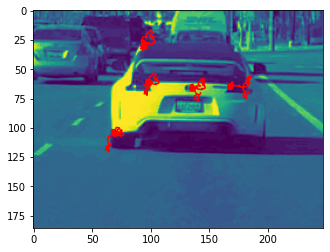

In [ ]:
plt.figure()
plt.imshow(imgs[0])
for feature in features:
  x, y = feature.ravel()
  plt.scatter(x, y, c = 'red')

for i in range(len(trajectories)):
  plt.plot(*zip(*trajectories[i]), c = 'red')

No feature disappeared. This is seen both through our code that would print out message if any feature disappears, and through the plot, as no feature moved out of the frame or is obstructed by anything in the image.

## Image Fusion

### Question 3
Now, we will select one feature out of all the extracted features (select a feature that does not disappear). Use the seleted feature and its estimated position in all frames to calculate relative motion across all frames (use the option that gave more accurate estimation of the ones you calculated in **Question 2**). You will use the first frame as reference and calculate the relative motion between the reference frame and all other frames. (The reason we are doing this is that the output from **Question 2** only gives you the position of features for each frame. It does not directly tell you the relative motion across frames).

### Answer

In [ ]:
motion = []
orig_x, orig_y = trajectories[1][0]

for x in range(len(imgs)):
  nx, ny = trajectories[1][x]
  dx = nx - orig_x
  dy = ny - orig_y
  motion.append((dx, dy))

### Question 4
Fuse all frames into a single frame using the translation vectors you calculated in **Question 3** and plot the result. Also, plot the corresponding result by simply merging all frames without any motion compensation. Comment on the differences between two merged frames.

### Answer

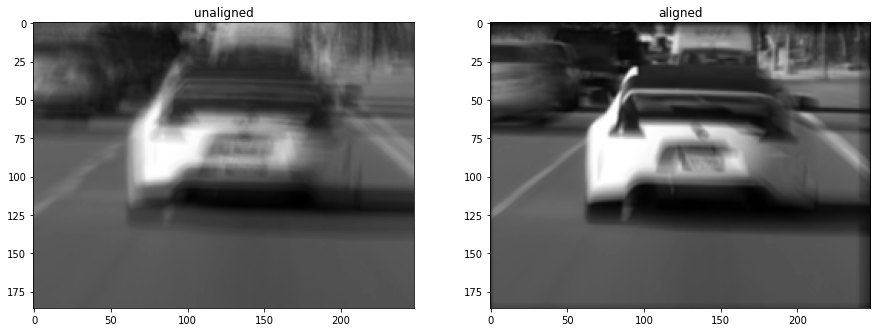

In [ ]:
def fuse_frames(imgs):
  unaligned = np.zeros_like(imgs[0], dtype='f')
  aligned = np.zeros_like(imgs[0], dtype='f')
  ###alignment
  nr, nc = imgs[0].shape

  for f in range( len(imgs) ):
    T = np.array([[1., 0., -float(motion[f][0])], [0., 1., -float(motion[f][1])]])
    aligned_frame = cv2.warpAffine( imgs[f], T, (nc,nr) )
    aligned += aligned_frame

  # merging frames without motion compensation
  for i in range(len(imgs)):
    unaligned += imgs[i]

  return unaligned, aligned

unaligned, aligned = fuse_frames(imgs)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.title("unaligned")
plt.imshow(unaligned, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("aligned")
plt.imshow(aligned, cmap="gray")

The unaligned image seems like a blurry image of the car in motion - you can see ghosting and double edges. The aligned image, on the other hand, has more defined borders and eliminated the ghosting effects. This makes sense because the aligned image stacked the original images, moved by the negative of their translation vectors relative to the original frame, together.

## Noise Suppresion

### Question 5
We will now investigate how burst photography can reduce the effect of noise. To do this, first, we will corrupt all the frames from the car sequence with Gaussian noise $\mu = 0, \sigma = 0.5$. You will first normalize all the images to the range $[0,1]$ and then plot all the corrupted frames.

### Answer

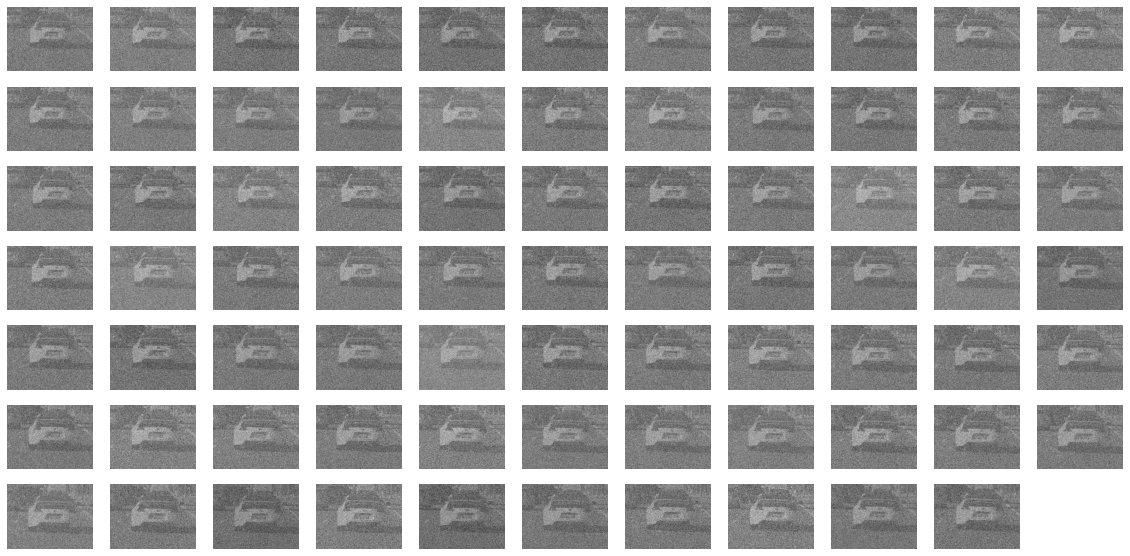

In [ ]:
def normalize(img):
  result = (img - np.min(img))/(np.max(img) - np.min(img))
  return result

def add_gaussian_noise(img, mean, sigma):
  img = np.float32(img)
  gaussian  = np.random.normal(mean, sigma, (img.shape[0],img.shape[1]))
  result = img + gaussian
  return result

fig = plt.figure(figsize=(20,10))

noisy_imgs = imgs.copy()
rows, cols = 7, 11
k = 0
while k < len(noisy_imgs):
  noisy_imgs[k] = normalize(noisy_imgs[k])
  noisy_imgs[k] = add_gaussian_noise(noisy_imgs[k], 0, 0.5)
  ax = plt.subplot(rows,cols,k+1)
  ax.imshow(noisy_imgs[k], cmap='gray')
  ax.axis('off')
  k += 1

### Question 6

We will now repeat the image fusion we did in **Question 4**. Instead of using clean frames, this time, we will use noise corrupted frames we got in **Question 5**. We will use the same motion vectors as in **Question 4**. Plot the fused frame and the reference frame (which is the first noisy image). Are you able to reduce noise by merging frames?

### Answer

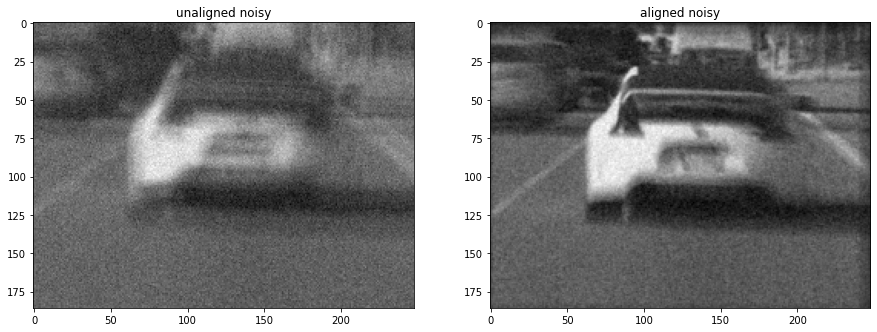

In [ ]:
unaligned_noisy, aligned_noisy = fuse_frames(noisy_imgs)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.title("unaligned noisy")
plt.imshow(unaligned_noisy, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("aligned noisy")
plt.imshow(aligned_noisy, cmap="gray")

Yes, we reduced noise by merging frames.

## Further image enhancement

### Question 7
In order to enhance the fused image, we will apply non-local means (NLM) denoising as we did in homework 1. Denoise the fused image and plot the result. Try to improve the fused image using at least one other enhancement technique and plot the result.

### Answer

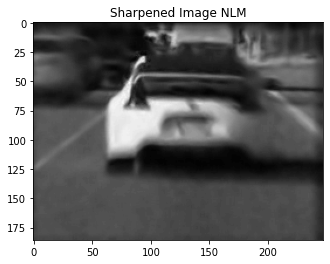

In [ ]:
aligned_noisy_converted = cv2.convertScaleAbs(aligned_noisy)
sharpen_fused_nlm = cv2.fastNlMeansDenoising(aligned_noisy_converted, None, 5, 11, 7)
plt.title("Sharpened Image NLM")
plt.imshow(sharpen_fused_nlm, cmap = "gray")
plt.show()

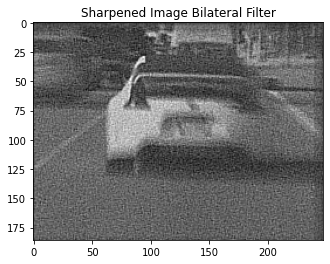

In [ ]:
def LoG(img, kernel, sigma):
  blur_img = cv2.GaussianBlur(img, (kernel, kernel), sigma)
  return cv2.Laplacian(img, ddepth = -1, ksize = kernel)

bilateral_fused_img = cv2.bilateralFilter(aligned_noisy, 10, 1, 3);

##sharpen image
sharpen_fused = bilateral_fused_img + (-0.3* LoG(bilateral_fused_img, kernel = 3, sigma = 0.1))

plt.title("Sharpened Image Bilateral Filter")
plt.imshow(sharpen_fused, cmap = "gray")
plt.show()